In [171]:
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt


In [172]:
import pandas as pd

df = pd.read_csv('../data/new_incidents.csv')

# Data Cleaning

The names of the counties are not consistent, so we need to unify them. We will use fuzzywuzzy's matching to find similar names and try to preprocess the strings to minimize the number of typos and abbreviations. We will also remove punctuation characters and extra spaces, and transform the names to title case. For a few cases where the names are very different, we will use a mapping dictionary to unify the ones we noticed.

In [173]:
# filter the incidents where year is between 2014 and 2017 and create the is_killed label
df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df["is_killed"] = df["n_killed"] > 0

In [174]:
from fuzzywuzzy import fuzz

# Group counties by state
grouped_by_state = df.groupby('state')['city_or_county'].unique()

if False:  # Set to True to run the fuzzy matching
    # Iterate through each state
    for state, counties_in_state in grouped_by_state.items():
        # Iterate through each pair of counties within the state
        for i in range(len(counties_in_state)):
            for j in range(i + 1, len(counties_in_state)):
                similarity_ratio = fuzz.ratio(counties_in_state[i], counties_in_state[j])
                if similarity_ratio > 90:  # Adjust the threshold as needed
                    print(
                        f"Similarity between '{counties_in_state[i]}' and '{counties_in_state[j]}' in {state} - Ratio: {similarity_ratio}")

In [175]:
# preprocess county names to unify typos and different abbreviations
counties = df['city_or_county'].unique()
# Apply a regex-based replacement to unify the "county" suffix
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+\(county\)$', ' County', regex=True)
# Replace punctuation characters with spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'[^\w\s]|(?<=\w)-(?=\w)', ' ', regex=True)
# Replace 'St ' with 'Saint'
df['city_or_county'] = df['city_or_county'].str.replace(r'\bSt\b', 'Saint', regex=True)
# Replace "Pk" with "Park"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bPk\b', 'Park', regex=True)
# Replace "Mt" with "Mount"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bMt\b', 'Mount', regex=True)
# Replace "Twp" with "Township"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bTwp\b', 'Township', regex=True)
# Replace "Washingtn" with "Washington"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bWashingtn\b', 'Washington', regex=True)

# Remove extra spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+', ' ', regex=True)
# Transform to title case and strip leading and trailing spaces
df['city_or_county'] = df['city_or_county'].str.strip().str.title()

# Mapping dictionary for unifying similar names, found with fuzzy matching
unify_dict = {
    'Denver Northglenn': 'Denver North Glenn',
    'Baton Rogue': 'Baton Rouge',
    'Marrrero': 'Marrero',
    'Prince George S County': 'Prince Georges County',
    'Genessee County': 'Genesee County',
    'O Fallon Ofallon': 'O Fallon O Fallon',
    'Doña Ana County': 'Dona Ana County',
    'Ullster County': 'Ulster County',
    'Nelsonvlle': 'Nelsonville',
    'Wolf Creek Sunnyvalley': 'Wolf Creek Sunny Valley',
    'Pittsburgh Bellvue': 'Pittsburgh Bellevue',
    'Mojave County': 'Mohave County',
    'New York Manhattan': 'Manhattan'
}

df['city_or_county'] = df['city_or_county'].replace(unify_dict)

# Score Calculation
We will calculate a score for each incident, based on the number of participants and how serious it was. We will assign heavier weights to incidents with more victims, and we will also consider the number of unharmed participants as negative weight. Then, we will group the incidents by year and week, to calculate the sum of the scores for each week later.

In [176]:
# Extract a time series for each city, computing for each week of the 4 years a score
df['date'] = pd.to_datetime(df['date'])
df['score'] = (df.n_participants * 0.5 + df.n_killed * 2 + df.n_injured - 0.25 * df.n_unharmed) / df.n_participants


# Define a function to calculate the unique week index considering leap years
def calculate_unique_week(date):
    if date.year == 2016:  # account for the leap year
        return date.isocalendar().week + (date.year - 2014) * 53
    else:
        return date.isocalendar().week + (date.year - 2014) * 52


# Apply the function to create the unique week index column
df['week'] = df['date'].apply(calculate_unique_week)

# Filter Cities
We will filter the cities to keep only the ones with a significant number of incidents. We will calculate the percentage of weeks with incidents for each city, and we will keep only the ones with more than 25% weeks with incidents. This will help to avoid having too many time series with a lot of missing values.

In [177]:
# Group by city and week, count incidents, and calculate score
grouped = df.groupby([df['city_or_county'],
                      df['week']]).size().reset_index(name='incident_count')
# Count total weeks for each city
city_week_counts = grouped['city_or_county'].value_counts()

# Calculate the total number of weeks from 2014 to 2017
total_weeks = len(grouped['week'].unique())

# Calculate percentage of weeks with incidents for each city
city_week_percentage = city_week_counts / total_weeks

# Filter cities with more than 25% weeks with incidents
selected_cities = city_week_percentage[city_week_percentage > 0.25].index
filtered = df[df['city_or_county'].isin(selected_cities)]
# Filter the grouped DataFrame for selected cities
filtered_grouped = filtered.groupby([df['city_or_county'],
                                     df['week']])['score'].sum().reset_index()

In [178]:
filtered_grouped

,city_or_county,week,score
0,Abilene,4,0.875000
1,Abilene,22,1.000000
2,Abilene,23,1.833333
3,Abilene,24,1.500000
4,Abilene,27,0.875000
...,...,...,...
41160,Ypsilanti,192,1.750000
41161,Ypsilanti,194,1.500000
41162,Ypsilanti,195,0.500000
41163,Ypsilanti,203,2.750000


# Time Series 

In [179]:
# Pivot the DataFrame to create the time series
time_series = filtered_grouped.pivot(index='city_or_county', columns='week', values='score')

# Optionally, fill missing values with 0 if a city has no incidents in a certain week
time_series.fillna(0, inplace=True)

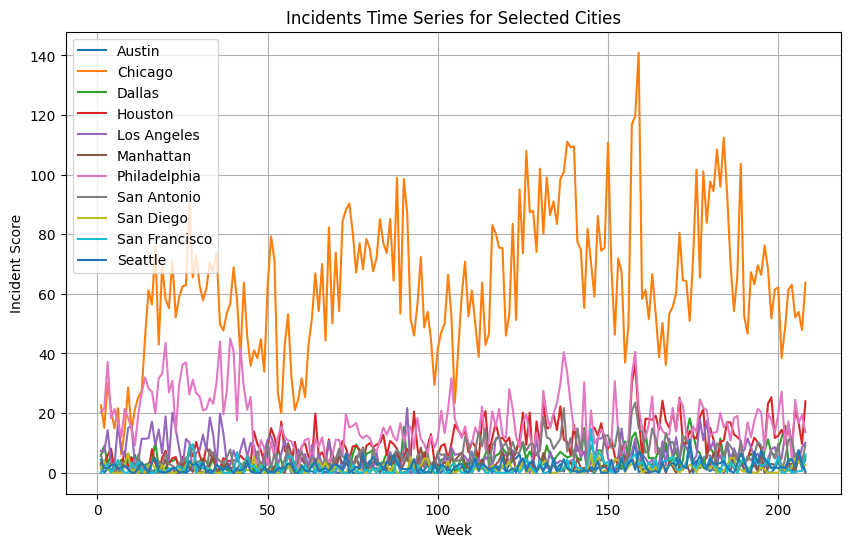

In [180]:
cities_to_plot = ['Austin', 'Chicago', 'Dallas', 'Houston', 'Los Angeles', 'Manhattan', 'Philadelphia', 'San Antonio',
                  'San Diego', 'San Francisco', 'Seattle']
plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

# Detrending

Check for stationarity using the Augmented Dickey-Fuller test

In [181]:
from statsmodels.tsa.stattools import adfuller

non_stationary_cities = []

for city in time_series.columns:
    adf = adfuller(time_series[city])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_cities.append(city)

print(len(non_stationary_cities))

0


In [182]:
time_series_detrend = time_series.copy()
for col in non_stationary_cities:
    time_series_detrend[col] = time_series[col] - time_series[col].rolling(window=12, min_periods=1).mean()

## Denoising

In [183]:
import numpy as np

noise_windows = np.array(range(1, 15))

# Dictionary to store mean SAD scores for each window size
mean_sad_dict = {}

for window_size in noise_windows:
    sum_abs_diff_weeks = []

    for week in time_series_detrend.index:
        smoothed_series = time_series_detrend.loc[week].rolling(window=window_size, center=True, min_periods=1).mean()
        sum_abs_diff_single_per_week = np.sum(np.abs(smoothed_series - time_series_detrend.loc[week]))
        sum_abs_diff_weeks.append(sum_abs_diff_single_per_week)

    mean_sad_dict[window_size] = np.average(sum_abs_diff_weeks)

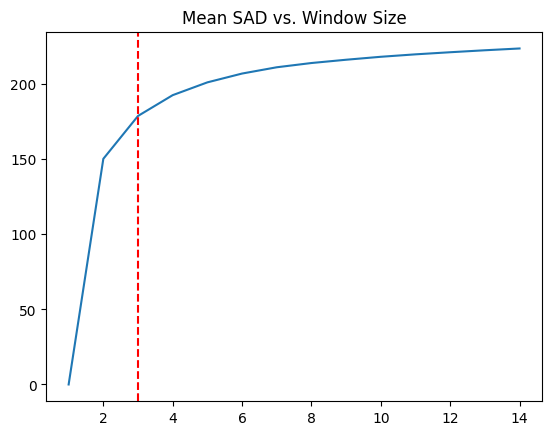

In [184]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(3, color='red', linestyle='--')
plt.title('Mean SAD vs. Window Size')
plt.show()

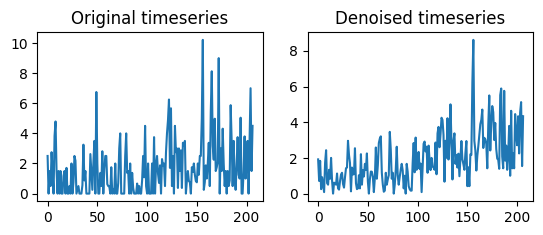

In [185]:
# Denoise the time series with found window size
time_series_denoised = time_series_detrend.rolling(window=3, center=True, min_periods=1).mean()

ts_example = time_series.loc['Austin']
ts_example_denoised = time_series_denoised.loc['Austin']

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

plt.show()

## Scaling

In [186]:
# Normalize the time series with scaler mean variance
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaler = TimeSeriesScalerMeanVariance(0, .1)
time_series_normalized = scaler.fit_transform(time_series_denoised)

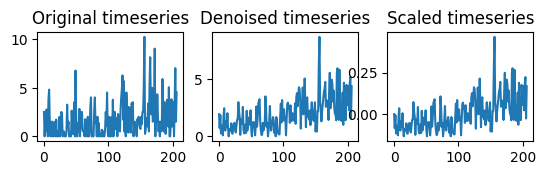

In [187]:
time_series = pd.DataFrame(time_series_normalized.squeeze(axis=-1), columns=time_series_denoised.columns,
                           index=time_series_denoised.index)
ts_example_scaled = time_series.loc['Austin']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

ax3.plot(ts_example_scaled.to_numpy())
ax3.set_title('Scaled timeseries')
ax3.set_box_aspect(3 / 4)
plt.show()

In [188]:
cities_to_plot = ['Austin', 'Chicago', 'Dallas', 'Houston', 'Los Angeles', 'Manhattan', 'Philadelphia', 'San Antonio',
                  'San Diego', 'San Francisco', 'Seattle']

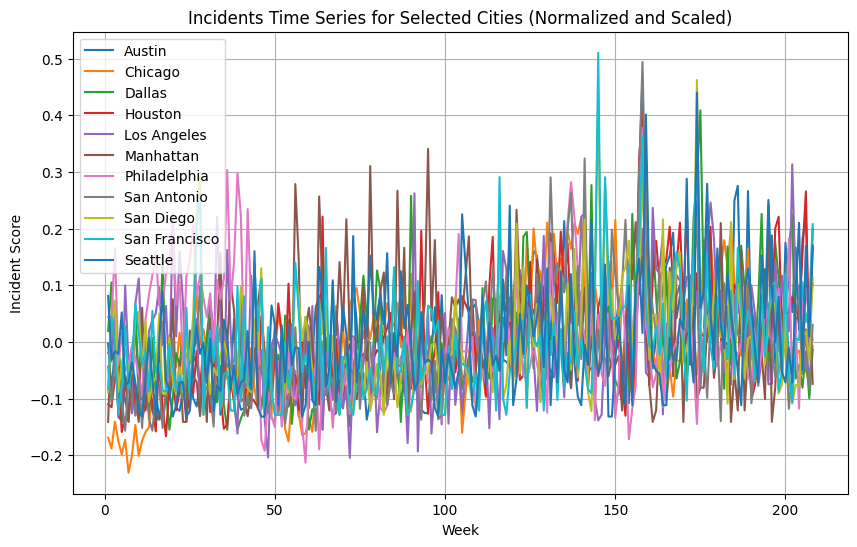

In [189]:
plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities (Normalized and Scaled)')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

# KMeans Clustering

In [190]:
from tslearn.clustering import TimeSeriesKMeans

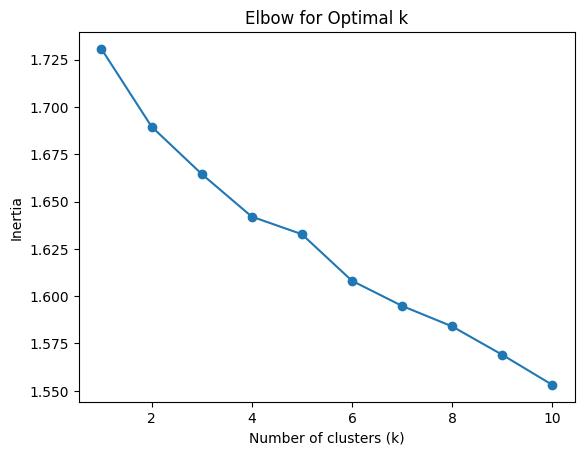

In [191]:
time_series_T = time_series.copy()
inertia = []
for k in range(1, 11):
    model = TimeSeriesKMeans(n_clusters=k)
    model.fit(time_series_T)
    inertia.append(model.inertia_)

# Plot the inertia values against k
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow for Optimal k')
plt.show()

In [192]:
n_clusters = 4  # You can adjust the number of clusters as needed
kmeans = TimeSeriesKMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(time_series_T)

Cluster 1 length: 62
Cluster 2 length: 138
Cluster 3 length: 88
Cluster 4 length: 76


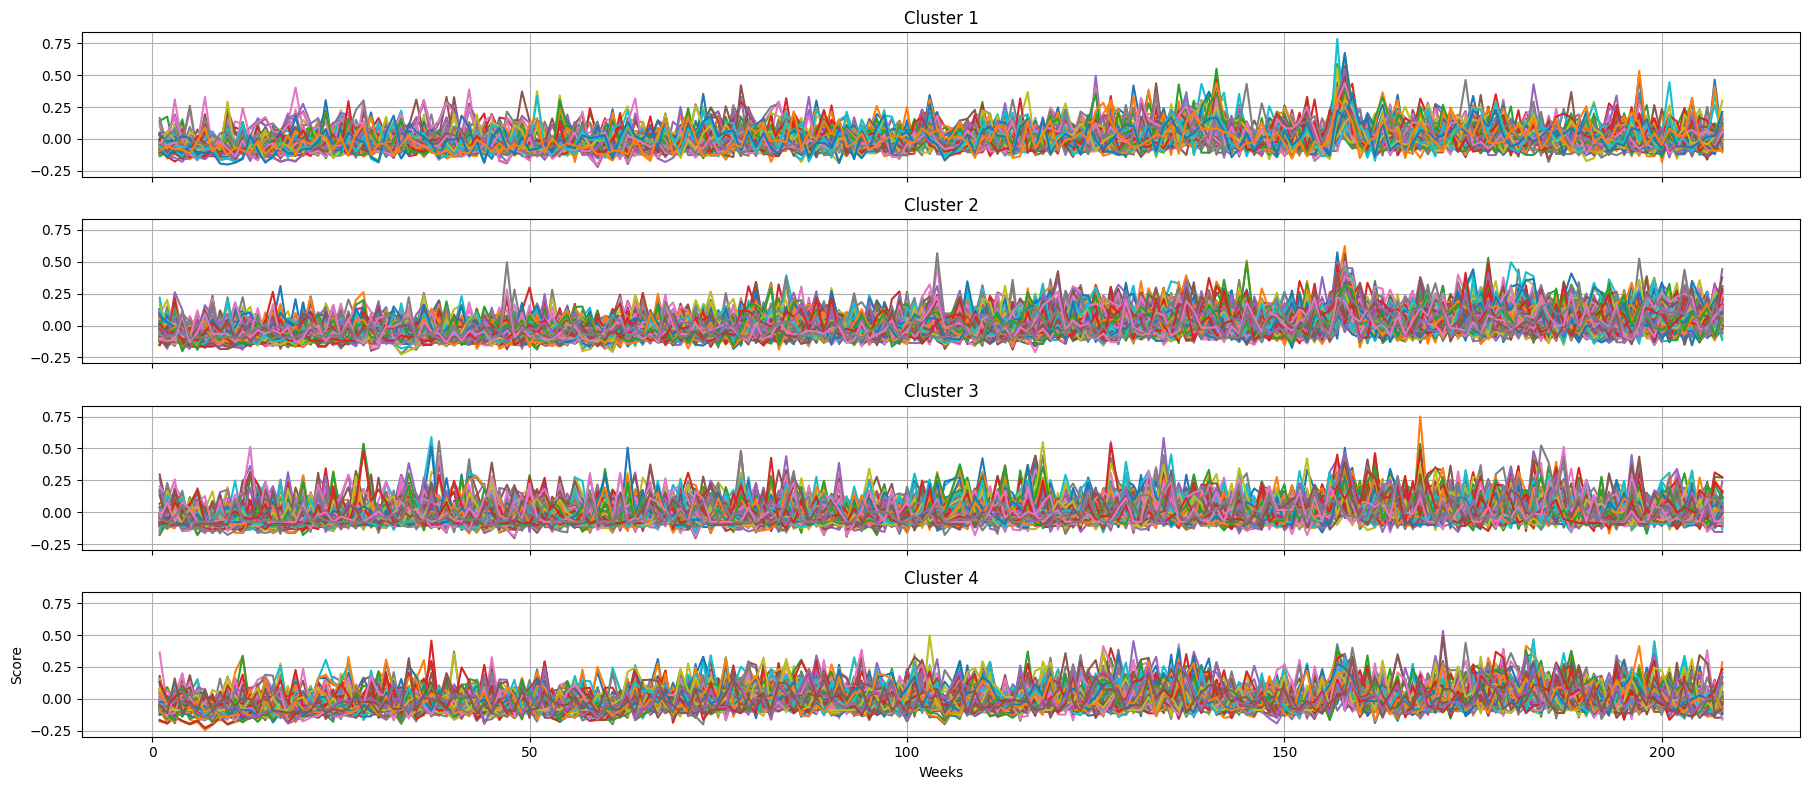

In [193]:
fig, axs = plt.subplots(n_clusters, figsize=(18, 8), sharex=True, sharey=True)
colors = ['blue', 'red', 'green', 'orange']  # Assign different colors for each cluster

# Plot the clustered time series data
for cluster in range(n_clusters):
    cluster_indices = [idx for idx, label in enumerate(cluster_labels) if label == cluster]
    for idx in cluster_indices:
        axs[cluster].plot(time_series_T.columns, time_series_T.iloc[idx])

    axs[cluster].set_title(f'Cluster {cluster+1}')
    axs[cluster].grid(True)
    print(f'Cluster {cluster+1} length: {len(cluster_indices)}')


plt.xlabel('Weeks')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [194]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series_T.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')


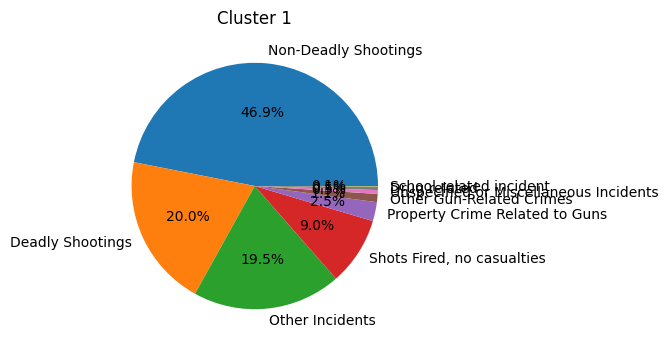

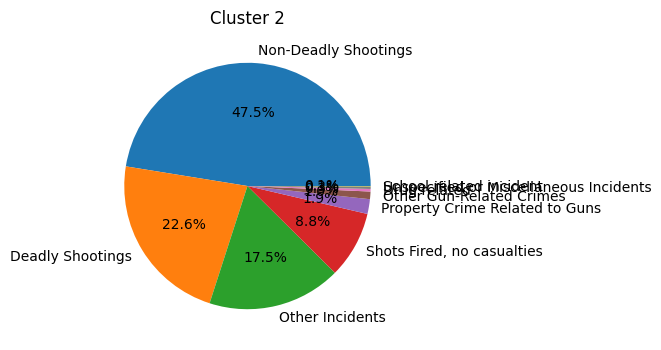

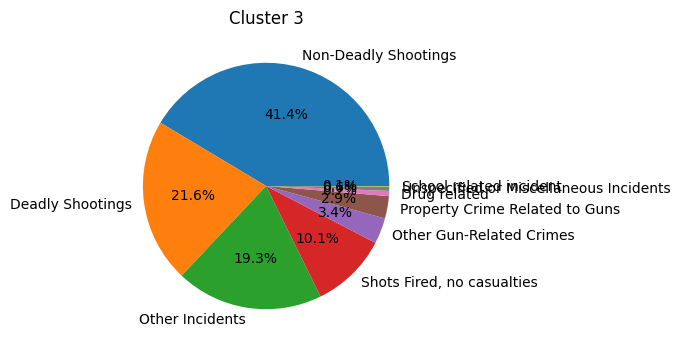

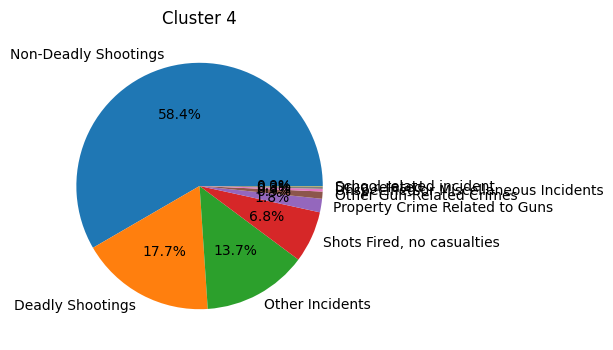

In [195]:
colors = plt.cm.tab10.colors  # You can use any other color map or define your own colors

# Iterate through clusters and plot pie charts with consistent colors
for cluster in range(n_clusters):
    plt.figure(figsize=(4, 4))
    cluster_df = clustered_df[clustered_df['cluster_id'] == cluster]
    incident_counts = cluster_df['incident_category'].str.split('|', expand=True).stack().value_counts().head(10)
    
    # Plot pie chart with consistent colors from the defined palette
    plt.pie(incident_counts, labels=incident_counts.index, colors=colors, autopct='%1.1f%%')
    plt.title(f'Cluster {cluster + 1}')
    plt.show()

In [196]:
# by using latitudes and longitudes, we can plot the clusters on a map
import plotly.express as px

grouped_data = clustered_df.groupby('city_or_county').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

# Get the cluster_id for each city_or_county
cluster_info = clustered_df[['city_or_county', 'cluster_id']].drop_duplicates()

# Merge cluster information with the grouped data
grouped_data = pd.merge(grouped_data, cluster_info, on='city_or_county')

# Create a scatter plot on the map using Plotly Express
fig = px.scatter_mapbox(grouped_data, lat='latitude', lon='longitude', color='cluster_id',
                        color_continuous_scale='Viridis', zoom=3, height=500,
                        hover_name='city_or_county')

# Update map layout and style
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Show the map
fig.show()


## Time Warping variant

In [197]:
n_clusters = 4  # You can adjust the number of clusters as needed
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter= 20)
cluster_labels = kmeans.fit_predict(time_series_T)

Cluster 1 length: 15
Cluster 2 length: 123
Cluster 3 length: 48
Cluster 4 length: 178


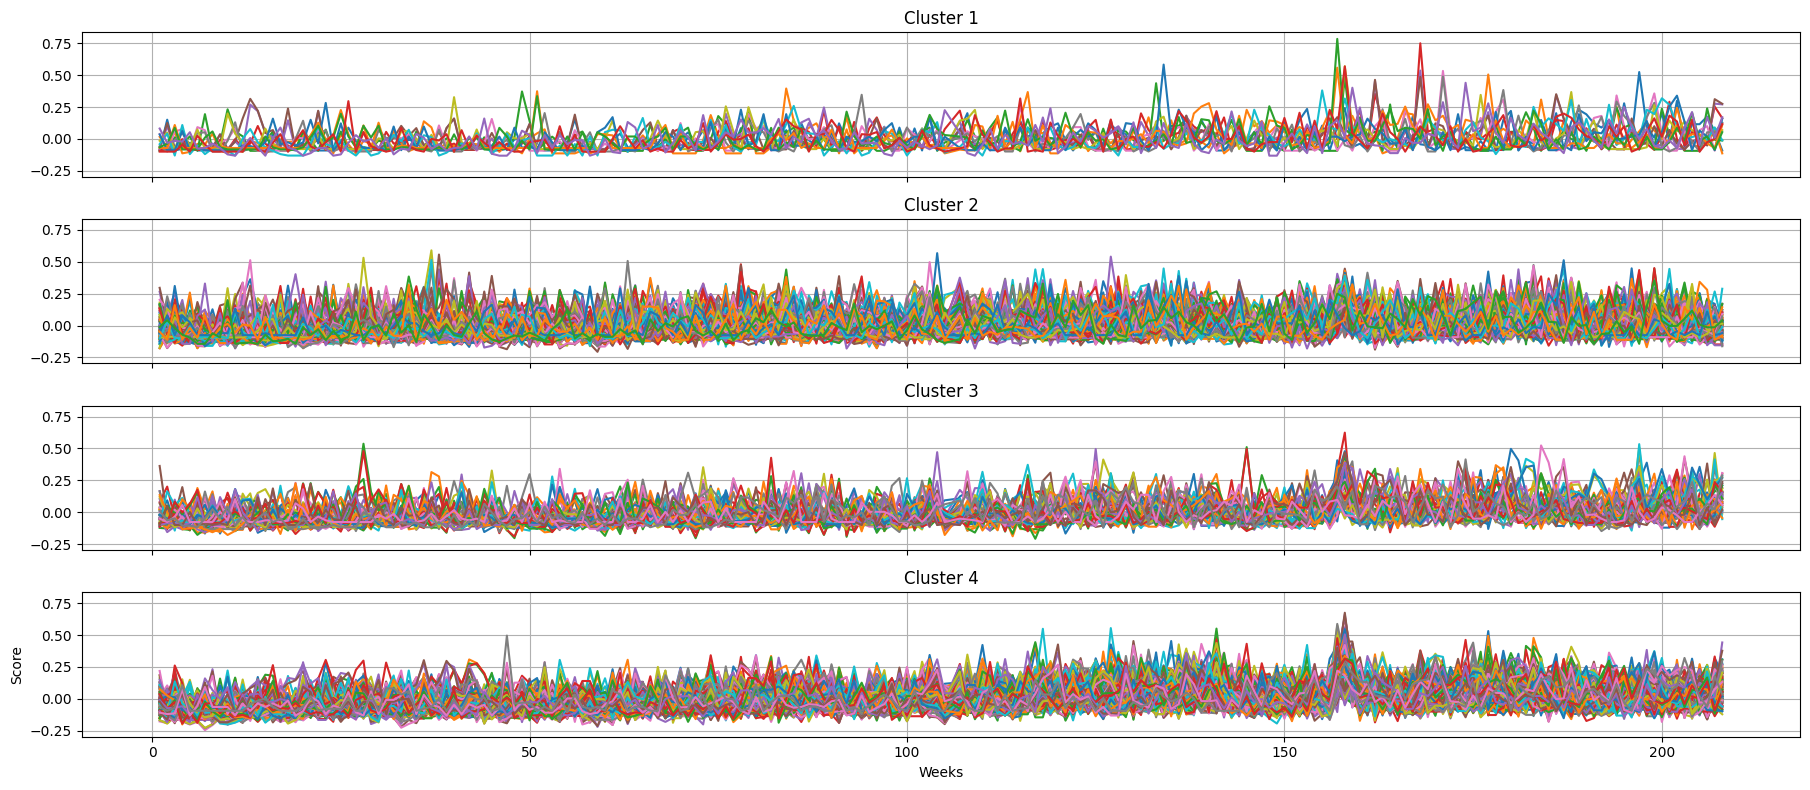

In [198]:
fig, axs = plt.subplots(n_clusters, figsize=(18, 8), sharex=True, sharey=True)
colors = ['blue', 'red', 'green', 'orange']  # Assign different colors for each cluster

# Plot the clustered time series data
for cluster in range(n_clusters):
    cluster_indices = [idx for idx, label in enumerate(cluster_labels) if label == cluster]
    for idx in cluster_indices:
        axs[cluster].plot(time_series_T.columns, time_series_T.iloc[idx])

    axs[cluster].set_title(f'Cluster {cluster+1}')
    axs[cluster].grid(True)
    print(f'Cluster {cluster+1} length: {len(cluster_indices)}')


plt.xlabel('Weeks')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [199]:
# create a new dataframe with the cluster labels and the city names
clustered_cities_dtw = pd.DataFrame({'city_or_county': time_series_T.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df_dtw = pd.merge(filtered, clustered_cities_dtw, on='city_or_county')

In [200]:

import plotly.express as px

grouped_data = clustered_df.groupby('city_or_county').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

# Get the cluster_id for each city_or_county
cluster_info = clustered_df[['city_or_county', 'cluster_id']].drop_duplicates()

# Merge cluster information with the grouped data
grouped_data = pd.merge(grouped_data, cluster_info, on='city_or_county')

# Create a scatter plot on the map using Plotly Express
fig = px.scatter_mapbox(grouped_data, lat='latitude', lon='longitude', color='cluster_id',
                        color_continuous_scale='Viridis', zoom=3, height=500,
                        hover_name='city_or_county')

# Update map layout and style
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

# Show the map
fig.show()